## Integrantes:
- Luis Francisco Rodriguez Acevedo


# Modelo para la clasificación con hiper parametros

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [3]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.8 MB/s eta 0:00:00


In [4]:
import os
import shutil
import keras_tuner
import numpy as np
import tensorflow as tf
from skopt import gp_minimize
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

<ipython-input-4-a25235b67d56>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Cargar el Dataset y crear la nueva ubicacion

In [12]:
original_dir = '/content/drive/MyDrive/Vision_computo/clase11'

base_dir = '/content/drive/MyDrive/Vision_computo/clase12'
os.makedirs(base_dir, exist_ok=True)

categories = ['good_quality', 'bad_quality']

## Preparacion los datos de imágenes de limones

In [13]:
for category in categories:
    os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)

for category in categories:
    category_dir = os.path.join(original_dir, category)
    file_list = os.listdir(category_dir)

    train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.2, random_state=42)

    for file_name in train_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'train', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in valid_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'validation', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in test_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'test', category, file_name)
        shutil.copyfile(src, dst)

for split in ['train', 'validation', 'test']:
    for category in categories:
        category_dir = os.path.join(base_dir, split, category)
        print(f"{split} {category} images: {len(os.listdir(category_dir))}")

train good_quality images: 900
train bad_quality images: 760
validation good_quality images: 180
validation bad_quality images: 152
test good_quality images: 45
test bad_quality images: 39


Procesa las imágenes de los directorios de entrenamiento, validación y prueba. Para redimensiona las imágenes, normaliza los valores de los píxeles y organiza las imágenes en lotes, facilitando la alimentación de datos al modelo durante el entrenamiento y la evaluación.

In [14]:
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1660 images belonging to 2 classes.
Found 332 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


## Definir un modelo de red neuronal convolucional y optimizar sus hiperparámetros

In [15]:
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv2_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv3_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner',
    project_name='lemon_quality')

tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=15,
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 5 Complete [00h 02m 25s]
val_accuracy: 0.9849397540092468

Best val_accuracy So Far: 0.9849397540092468
Total elapsed time: 00h 12m 58s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32

 ## Crear una arquitectura de red neuronal convolucional para la clasificación binaria de imágenes.

In [16]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/15
51/51 [==============================] - 12s 190ms/step - loss: 0.5062 - accuracy: 0.7549 - val_loss: 0.3759 - val_accuracy: 0.8531
Epoch 2/15
51/51 [==============================] - 9s 174ms/step - loss: 0.3128 - accuracy: 0.8673 - val_loss: 0.2432 - val_accuracy: 0.9312
Epoch 3/15
51/51 [==============================] - 9s 186ms/step - loss: 0.2134 - accuracy: 0.9134 - val_loss: 0.2552 - val_accuracy: 0.8906
Epoch 4/15
51/51 [==============================] - 8s 163ms/step - loss: 0.1457 - accuracy: 0.9423 - val_loss: 0.0912 - val_accuracy: 0.9688
Epoch 5/15
51/51 [==============================] - 9s 174ms/step - loss: 0.0982 - accuracy: 0.9681 - val_loss: 0.1120 - val_accuracy: 0.9563
Epoch 6/15
51/51 [==============================] - 10s 198ms/step - loss: 0.0916 - accuracy: 0.9644 - val_loss: 0.0835 - val_accuracy: 0.9719
Epoch 7/15
51/51 [==============================] - 10s 187ms/step - loss: 0.0977 - accuracy: 0.9699 - val_loss: 0.1210 - val_accuracy: 0.9656
Epo

In [17]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_accuracy}')

2/2 [==============================] - 0s 185ms/step - loss: 0.0814 - accuracy: 0.9688
Test accuracy: 0.96875


## Comprobar el modelo

1/1 [==============================] - 0s 22ms/step


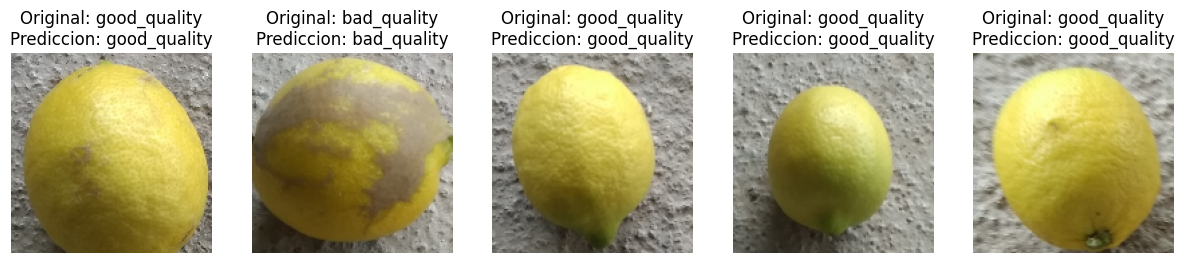

In [19]:
def show_predictions(model, generator, class_labels, num_images=5):
    x, y = next(generator)
    predictions = model.predict(x)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        true_label = int(y[i])
        pred_label = int(predictions[i][0] > 0.5)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x[i])
        plt.title(f"Original: {class_labels[true_label]}\nPrediccion: {class_labels[pred_label]}")
        plt.axis('off')
    plt.show()

class_labels = list(train_generator.class_indices.keys())

show_predictions(model, test_generator, class_labels, num_images=5)